In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#hyperparmeter
vocab_size = 10000  
embedding_dim = 16   
max_length = 100    
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000 # 7000 out of 27000 for validation


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-10-02 15:48:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-10-02 15:48:05 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

Building a classifier for the sarcasm dataset

In [6]:
#split by slicing 
training_sentences = sentences[0:training_size]  #20,000
testing_sentences = sentences[training_size:]    #20,000~27,000
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6633 - accuracy: 0.5843 - val_loss: 0.5801 - val_accuracy: 0.7529
Epoch 2/30
625/625 - 3s - loss: 0.4346 - accuracy: 0.8314 - val_loss: 0.3862 - val_accuracy: 0.8408
Epoch 3/30
625/625 - 2s - loss: 0.3108 - accuracy: 0.8777 - val_loss: 0.3550 - val_accuracy: 0.8517
Epoch 4/30
625/625 - 2s - loss: 0.2582 - accuracy: 0.9014 - val_loss: 0.3442 - val_accuracy: 0.8553
Epoch 5/30
625/625 - 3s - loss: 0.2241 - accuracy: 0.9141 - val_loss: 0.3438 - val_accuracy: 0.8575
Epoch 6/30
625/625 - 2s - loss: 0.1968 - accuracy: 0.9251 - val_loss: 0.3527 - val_accuracy: 0.8566
Epoch 7/30
625/625 - 3s - loss: 0.1754 - accuracy: 0.9338 - val_loss: 0.3854 - val_accuracy: 0.8417
Epoch 8/30
625/625 - 2s - loss: 0.1568 - accuracy: 0.9428 - val_loss: 0.3786 - val_accuracy: 0.8523
Epoch 9/30
625/625 - 2s - loss: 0.1415 - accuracy: 0.9481 - val_loss: 0.3908 - val_accuracy: 0.8550
Epoch 10/30
625/625 - 2s - loss: 0.1284 - accuracy: 0.9553 - val_loss: 0.4097 - val_accuracy: 0.8521

- training loss는 줄고있는데 val_loss는 증폭

- 하이퍼파라미터 바꾸면서 차이를 봐야함
 - Keep working on them and see if you can find any combinations that give a 90 percent plus training accuracy without a cost of the lost function increasing sharply.

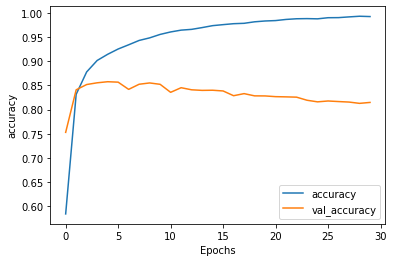

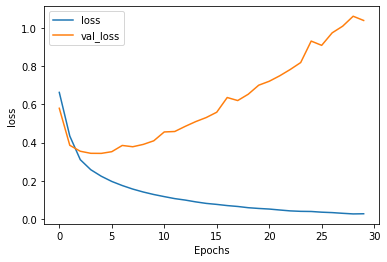

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Epoch 1/30
625/625 - 2s - loss: 0.6841 - accuracy: 0.5590 - val_loss: 0.6769 - val_accuracy: 0.5633
Epoch 2/30
625/625 - 2s - loss: 0.5955 - accuracy: 0.6908 - val_loss: 0.4969 - val_accuracy: 0.7870
Epoch 3/30
625/625 - 2s - loss: 0.4252 - accuracy: 0.8112 - val_loss: 0.4102 - val_accuracy: 0.8144
Epoch 4/30
625/625 - 2s - loss: 0.3736 - accuracy: 0.8359 - val_loss: 0.3883 - val_accuracy: 0.8272
Epoch 5/30
625/625 - 2s - loss: 0.3498 - accuracy: 0.8475 - val_loss: 0.3810 - val_accuracy: 0.8313
Epoch 6/30
625/625 - 2s - loss: 0.3348 - accuracy: 0.8532 - val_loss: 0.3739 - val_accuracy: 0.8344
Epoch 7/30
625/625 - 2s - loss: 0.3259 - accuracy: 0.8578 - val_loss: 0.3715 - val_accuracy: 0.8317
Epoch 8/30
625/625 - 2s - loss: 0.3183 - accuracy: 0.8610 - val_loss: 0.3792 - val_accuracy: 0.8219
Epoch 9/30
625/625 - 2s - loss: 0.3131 - accuracy: 0.8619 - val_loss: 0.3797 - val_accuracy: 0.8343
Epoch 10/30
625/625 - 2s - loss: 0.3071 - accuracy: 0.8656 - val_loss: 0.3804 - val_accuracy: 0.8346

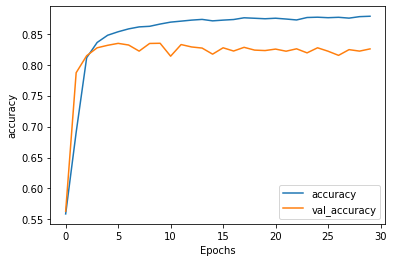

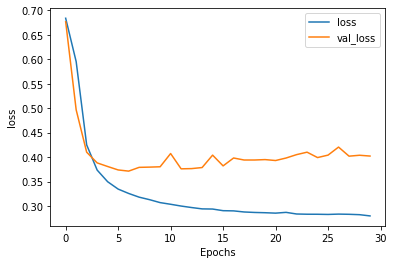

In [37]:
#hyperparmeter
vocab_size = 2000   #줄이면 val_loss 안정됨
embedding_dim = 12 
max_length = 200     #늘리면 acc 상승 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



num_epochs = 30
history = model.fit(training_padded, training_labels ,epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [23]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded)) # Sarcastic , not sarcastic

[[9.6402884e-01]
 [1.1403363e-05]]


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')